# 一、例外值處理與數值標準化
* 新增欄位註記
* outliers 或 NA 填補
    1. 平均數 (mean)
    2. 中位數 (median, or Q50)
    3. 最大/最小值 (max/min, Q100, Q0)
    4. 分位數 (quantile)

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

# 設定 data_path
dir_data = './data/'

Mounted at /content/drive


In [2]:
dir_data = '/content/drive/MyDrive/中大講師/中大講師/中大 - 天氣與人工智慧/111-1/20221123 機器學習實作3 資料清理數據前處理/data'
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: /content/drive/MyDrive/中大講師/中大講師/中大 - 天氣與人工智慧/111-1/20221123 機器學習實作3 資料清理數據前處理/data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 如果欄位中有 NA, describe 會有問題
app_train['AMT_ANNUITY'].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [ ]:
# Ignore NA, 計算五值
five_num = [0, 25, 50, 75, 100]
quantile_5s = [np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = i) for i in five_num]
print(quantile_5s)

[1615.5, 16524.0, 24903.0, 34596.0, 258025.5]


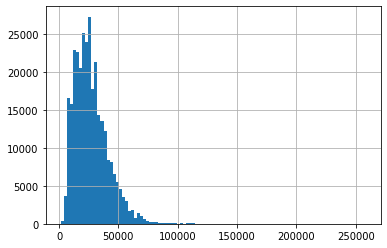

In [ ]:
app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'].hist(bins = 100)
plt.show()

In [4]:
# 試著將 max 取代為 q99
app_train[app_train['AMT_ANNUITY'] == app_train['AMT_ANNUITY'].max()] = np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = 99)

In [5]:
five_num = [0, 25, 50, 75, 100]
quantile_5s = [np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = i) for i in five_num]
print(quantile_5s)

[1615.5, 16524.0, 24903.0, 34596.0, 230161.5]


In [6]:
# 得到 median 的另外一種方法
np.median(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'])

24903.0

In [7]:
# 計算眾數 (mode)
from scipy.stats import mode
import time

start_time = time.time()
mode_get = mode(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'])
print(mode_get)
print("Elapsed time: %.3f secs" % (time.time() - start_time))

ModeResult(mode=array([9000.]), count=array([6385]))
Elapsed time: 0.138 secs


In [8]:
# 計算眾數 (mode)
# 較快速的方式
from collections import defaultdict

start_time = time.time()
mode_dict = defaultdict(lambda:0)

for value in app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY']:
    mode_dict[value] += 1
    
mode_get = sorted(mode_dict.items(), key=lambda kv: kv[1], reverse=True)
print(mode_get[0])
print("Elapsed time: %.3f secs" % (time.time() - start_time))

(9000.0, 6385)
Elapsed time: 0.290 secs


## 連續值標準化
### 1. Z-transform: $ \frac{(x - mean(x))}{std(x)} $
### 2. Range (0 ~ 1): $ \frac{x - min(x)}{max(x) - min(x)} $
### 3. Range (-1 ~ 1): $ (\frac{x - min(x)}{max(x) - min(x)} - 0.5) * 2 $

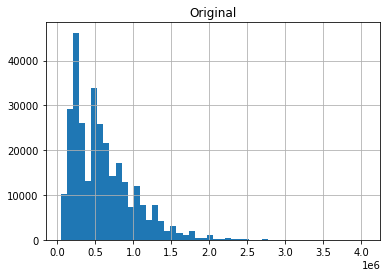

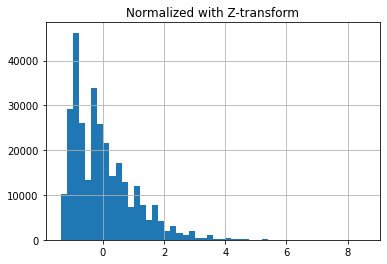

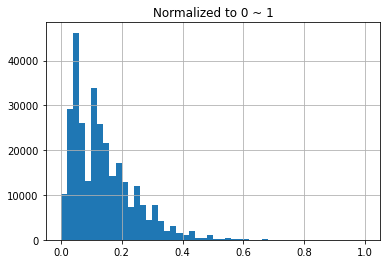

In [ ]:
# 以 AMT_CREDIT 為例
app_train['AMT_CREDIT'].hist(bins = 50)
plt.title("Original")
plt.show()
value = app_train['AMT_CREDIT'].values

app_train['AMT_CREDIT_Norm1'] = ( value - np.mean(value) ) / ( np.std(value) )
app_train['AMT_CREDIT_Norm1'].hist(bins = 50)
plt.title("Normalized with Z-transform")
plt.show()

app_train['AMT_CREDIT_Norm2'] = ( value - min(value) ) / ( max(value) - min(value) )
app_train['AMT_CREDIT_Norm2'].hist(bins = 50)
plt.title("Normalized to 0 ~ 1")
plt.show()

# It's your turn
### 1. 列出 AMT_ANNUITY 的 q0 - q100
### 2.1 將 AMT_ANNUITY 中的 NAs 暫時以中位數填補
### 2.2 將 AMT_ANNUITY 的數值標準化至 -1 ~ 1 間
### 3. 將 AMT_GOOD_PRICE 的 NAs 以眾數填補


In [ ]:
"""
YOUR CODE HERE
"""
# 1: 計算 AMT_ANNUITY 的 q0 - q100
q_all =

pd.DataFrame({'q': list(range(101)),
              'value': q_all})

In [ ]:
# 2.1 將 NAs 以 q50 填補
print("Before replace NAs, numbers of row that AMT_ANNUITY is NAs: %i" % sum(app_train['AMT_ANNUITY'].isnull()))

"""
Your Code Here
"""
q_50 = 
app_train.loc[app_train['AMT_ANNUITY'].isnull(),'AMT_ANNUITY'] = q_50

print("After replace NAs, numbers of row that AMT_ANNUITY is NAs: %i" % sum(app_train['AMT_ANNUITY'].isnull()))

### Hints: Normalize function (to -1 ~ 1)
$ y = 2*(\frac{x - min(x)}{max(x) - min(x)} - 0.5) $

In [ ]:
# 2.2 Normalize values to -1 to 1
print("== Original data range ==")
print(app_train['AMT_ANNUITY'].describe())

def normalize_value(x):
    """
    Your Code Here, compelete this function
    """
    
    return x

app_train['AMT_ANNUITY_NORMALIZED'] = normalize_value(app_train['AMT_ANNUITY'])

print("== Normalized data range ==")
app_train['AMT_ANNUITY_NORMALIZED'].describe()

== Original data range ==
count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64
== Normalized data range ==


count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY_NORMALIZED, dtype: float64

In [ ]:
# 3
print("Before replace NAs, numbers of row that AMT_GOODS_PRICE is NAs: %i" % sum(app_train['AMT_GOODS_PRICE'].isnull()))

# 列出重複最多的數值
"""
Your Code Here
"""
value_most = 
print(value_most)

mode_goods_price = list(app_train['AMT_GOODS_PRICE'].value_counts().index)
app_train.loc[app_train['AMT_GOODS_PRICE'].isnull(), 'AMT_GOODS_PRICE'] = mode_goods_price[0]

print("After replace NAs, numbers of row that AMT_GOODS_PRICE is NAs: %i" % sum(app_train['AMT_GOODS_PRICE'].isnull()))

SyntaxError: ignored

---

# 二、常用的 DataFrame 操作
* merge / transform
* subset
* groupby

In [9]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Merge / Transform

In [10]:
# 生成範例用的資料 ()
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],
           'B': ['B0', 'B1', 'B2', 'B3'],
           'C': ['C0', 'C1', 'C2', 'C3'],
           'D': ['D0', 'D1', 'D2', 'D3']},
           index=[0, 1, 2, 3])
df2 = pd.DataFrame({'A': ['A4', 'A5', 'A6', 'A7'],
           'B': ['B4', 'B5', 'B6', 'B7'],
           'C': ['C4', 'C5', 'C6', 'C7'],
           'D': ['D4', 'D5', 'D6', 'D7']},
           index=[4, 5, 6, 7])
df3 = pd.DataFrame({'A': ['A8', 'A9', 'A10', 'A11'],
           'B': ['B8', 'B9', 'B10', 'B11'],
           'C': ['C8', 'C9', 'C10', 'C11'],
           'D': ['D8', 'D9', 'D10', 'D11']},
           index=[8, 9, 10, 11])

df4 = pd.DataFrame({'B': ['B2', 'B3', 'B6', 'B7'],
           'D': ['D2', 'D3', 'D6', 'D7'],
           'F': ['F2', 'F3', 'F6', 'F7']},
           index=[2, 3, 6, 7])

In [11]:
df4

,B,D,F
2,B2,D2,F2
3,B3,D3,F3
6,B6,D6,F6
7,B7,D7,F7


In [12]:
# 沿縱軸合併
result = pd.concat([df1, df2, df3], axis = 0)
result

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3
4,A4,B4,C4,D4
5,A5,B5,C5,D5
6,A6,B6,C6,D6
7,A7,B7,C7,D7
8,A8,B8,C8,D8
9,A9,B9,C9,D9


In [ ]:
# 沿橫軸合併
result = pd.concat([df1, df4], axis = 1)
result

,A,B,C,D,B,D,F
0,A0,B0,C0,D0,NaN,NaN,NaN
1,A1,B1,C1,D1,NaN,NaN,NaN
2,A2,B2,C2,D2,B2,D2,F2
3,A3,B3,C3,D3,B3,D3,F3
6,NaN,NaN,NaN,NaN,B6,D6,F6
7,NaN,NaN,NaN,NaN,B7,D7,F7


In [ ]:
# 沿橫軸合併
result = pd.concat([df1, df4], axis = 1, join = 'inner') # 硬串接
print(result)

result = pd.merge(df1, df4, how = 'inner')
print(result)

    A   B   C   D   B   D   F
2  A2  B2  C2  D2  B2  D2  F2
3  A3  B3  C3  D3  B3  D3  F3
    A   B   C   D   F
0  A2  B2  C2  D2  F2
1  A3  B3  C3  D3  F3


In [13]:
# 將 欄-列 逐一解開
print(df1)
df1.melt()

    A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1
2  A2  B2  C2  D2
3  A3  B3  C3  D3


,variable,value
0,A,A0
1,A,A1
2,A,A2
3,A,A3
4,B,B0
5,B,B1
6,B,B2
7,B,B3
8,C,C0
9,C,C1


## Subset

In [ ]:
# 設定 data_path
dir_data = './data/'

In [ ]:
f_app = os.path.join(dir_data, 'application_train.csv')
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: /content/drive/MyDrive/中大講師/中大講師/中大 - 天氣與人工智慧/110-2/20220428 機器學習實作3 資料清理數據前處理/data/application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# 取 TARGET 為 1 的
sub_df = app_train[app_train['TARGET'] == 1]
sub_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,100031.0,1.0,Cash loans,F,N,Y,0.0,112500.0,979992.0,27076.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
40,100047.0,1.0,Cash loans,M,N,Y,0.0,202500.0,1193580.0,35028.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0
42,100049.0,1.0,Cash loans,F,N,N,0.0,135000.0,288873.0,16258.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
81,100096.0,1.0,Cash loans,F,N,Y,0.0,81000.0,252000.0,14593.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 取 AMT_INCOME_TOTAL 大於平均資料中，SK_ID_CURR, TARGET 兩欄
sub_df = app_train.loc[app_train['AMT_INCOME_TOTAL'] > app_train['AMT_INCOME_TOTAL'].mean(), ['SK_ID_CURR', 'TARGET']]
sub_df.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
6,100009,0
7,100010,0
13,100017,0


In [ ]:
sub1_df = app_train[app_train['AMT_INCOME_TOTAL'] > app_train['AMT_INCOME_TOTAL'].mean()][['SK_ID_CURR', 'TARGET']]
sub1_df

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
6,100009,0
7,100010,0
13,100017,0
...,...,...
307496,456240,0
307497,456241,0
307498,456242,0
307500,456244,0


## Groupby

In [ ]:
app_train.groupby(['NAME_CONTRACT_TYPE']).size()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
dtype: int64

In [ ]:
app_train.groupby(['NAME_CONTRACT_TYPE'])['AMT_INCOME_TOTAL'].describe()

,count,mean,std,min,25%,50%,75%,max
NAME_CONTRACT_TYPE,,,,,,,,
Cash loans,278232.0,169069.513575,245910.950896,25650.0,112500.0,153000.0,202500.0,117000000.0
Revolving loans,29279.0,166217.017656,126028.600660,27000.0,99000.0,135000.0,202500.0,4500000.0


In [ ]:
app_train.groupby(['NAME_CONTRACT_TYPE'])['TARGET'].mean()

NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
Name: TARGET, dtype: float64

In [ ]:
# 取前 10000 筆作範例: 分別將 AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY 除以根據 NAME_CONTRACT_TYPE 分組後的平均數，
app_train.loc[0:10000, ['NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']].groupby(['NAME_CONTRACT_TYPE']).apply(lambda x: x / x.mean())

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,NAME_CONTRACT_TYPE
0,0.871394,0.642827,1.205275,NaN
1,1.259386,2.045017,1.607034,NaN
2,0.430084,0.430829,0.415602,NaN
3,1.047292,0.494349,0.803517,NaN
4,0.771380,0.811049,0.723165,NaN
...,...,...,...,...
9996,1.818354,1.591933,0.991004,NaN
9997,1.890269,0.786575,1.339195,NaN
9998,0.975218,0.550603,2.142711,NaN
9999,0.661205,0.562100,0.562462,NaN


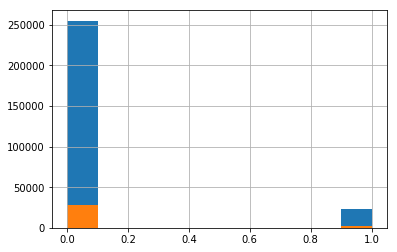

In [ ]:
app_train.groupby(['NAME_CONTRACT_TYPE'])['TARGET'].hist()
plt.show()

## 練習
1. 請將 app_train 中的 CNT_CHILDREN 依照下列規則分為四組，並將其結果在原本的 dataframe 命名為 CNT_CHILDREN_GROUP
    * 0 個小孩
    * 有 1 - 2 個小孩
    * 有 3 - 5 個小孩
    * 有超過 5 個小孩

2. 請根據 CNT_CHILDREN_GROUP 以及 TARGET，列出各組的平均 AMT_INCOME_TOTAL，並繪製 baxplot
3. 請根據 CNT_CHILDREN_GROUP 以及 TARGET，對 AMT_INCOME_TOTAL 計算 [Z 轉換](https://en.wikipedia.org/wiki/Standard_score) 後的分數

In [ ]:
#1
"""
Your code here
"""
cut_rule = 

app_train['CNT_CHILDREN_GROUP'] = pd.cut(app_train['CNT_CHILDREN'].values, cut_rule, include_lowest=True)
app_train['CNT_CHILDREN_GROUP'].value_counts()

In [ ]:
#2-1
"""
Your code here
"""
grp = 

grouped_df = app_train.groupby(grp)['AMT_INCOME_TOTAL']
grouped_df.mean()

In [ ]:
#2-2
"""
Your code here
"""
plt_column = 
plt_by = 

app_train.boxplot(column=plt_column, by = plt_by, showfliers = False, figsize=(12,12))
plt.suptitle('')
plt.show()

In [ ]:
#3
"""
Your code here
"""
app_train['AMT_INCOME_TOTAL_Z_BY_CHILDREN_GRP-TARGET'] = grouped_df.apply(lambda x: )

app_train[['AMT_INCOME_TOTAL','AMT_INCOME_TOTAL_Z_BY_CHILDREN_GRP-TARGET']].head()

---

# 三、相關係數
# [目標]
- 以下程式碼將示範在 python 如何利用 numpy 計算出兩組數據之間的相關係數，並觀察散佈圖
- 藉由觀察相關矩陣與散佈圖的關係, 希望同學對 弱相關 / 正相關 的變數分布情形有比較直覺的理解

# [範例重點]
- 弱相關的相關矩陣與散佈圖之間的關係
- 正相關的相關矩陣與散佈圖之間的關係

In [15]:
# 載入基礎套件
import numpy as np
np.random.seed(1)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### 弱相關

In [16]:
# 隨機生成兩組 1000 個介於 0~50 的整數 x, y, 看看相關矩陣如何
x = np.random.randint(0, 50, 1000)
y = np.random.randint(0, 50, 1000)

# 呼叫 numpy 裡的相關矩陣函數 (corrcoef)
np.corrcoef(x, y)

array([[1.        , 0.00404702],
       [0.00404702, 1.        ]])

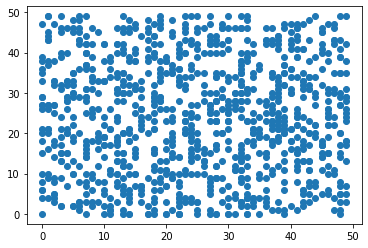

In [17]:
# 將分布畫出來看看吧
plt.scatter(x, y)
plt.show()

### 正相關

In [18]:
# 隨機生成 1000 個介於 0~50 的數 x
x = np.random.randint(0, 50, 1000)

# 這次讓 y 與 x 正相關，再增加一些雜訊
y = x + np.random.normal(0, 10, 1000)

# 再次用 numpy 裡的函數來計算相關係數
np.corrcoef(x, y)

array([[1.       , 0.8218465],
       [0.8218465, 1.       ]])

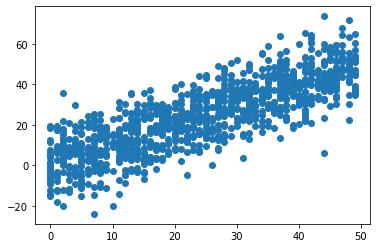

In [19]:
# 再看看正相關的 x,y 分布
plt.scatter(x, y)

### 練習
參考範例程式碼，模擬一組負相關的資料，並計算出相關係數以及畫出 scatter plot